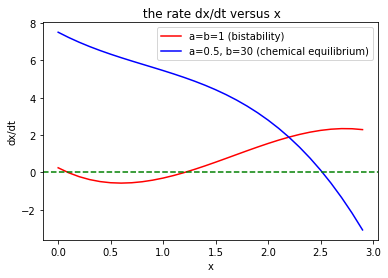

<ipython-input-3-64f3c59ffef2>:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  alpha=np.array([k1*a*x*(x-1)/VnA, k2*x*(x-1)*(x-2)/VnA**2, k3*b*VnA, k4*x])
/Users/maryamyousefian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


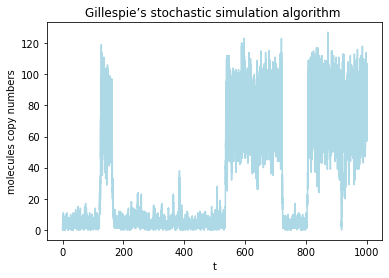

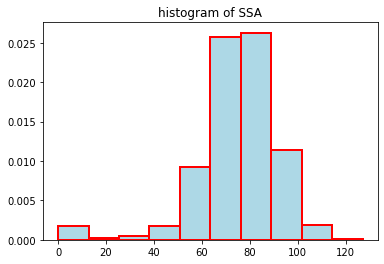

VnA is : 20
N is : 160
eigenvalues are: [-5.84060203e-10+0.j -9.32565370e-03+0.j]
VnA is : 40
N is : 320
eigenvalues are: [ 2.62570877e-14+0.j -6.92610448e-04+0.j]


/Users/maryamyousefian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/maryamyousefian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


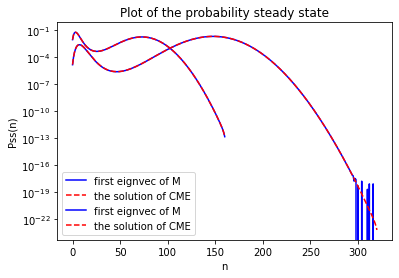

In [3]:
#Task number two, Schlögl model
#student name: Maryam yousefian

#Information that I derived: dx/dt=k1*a*x**2-k2*x**3-k4*x+k3*b (this is also in the paper)
#stoichiometric vector: [1,-1,1,-1]
# r for the first reaction=k1*x**2*A
# r for the second reaction=k2*x**3
# r for the third reaction=k3*B
# r for the last reaction=k4*x
# for the other info, I used the paper equations if needed!


#import the required libraries:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm
from scipy.sparse.linalg import eigs
import math


#Parameter values are:
k1=3
k2=0.6
k3=0.25
k4=2.95

a=b=1
VnA=20
par_arr=np.array([k1,k2,k3,k4,a,b,VnA])

#define schlögl function:
def schlögl(t,y,par_arr):
    #quantification
    k1=par_arr[0]
    k2=par_arr[1]
    k3=par_arr[2]
    k4=par_arr[3]
    a=par_arr[4]
    b=par_arr[5]

    #based on equation 2.3 in the paper:
    dy=k1*a*y**2-k2*y**3-k4*y+k3*b
    
    return dy

    
#define a function for propensities:
def propensities(n,par_arr):
    #quantification
    k1=par_arr[0]
    k2=par_arr[1]
    k3=par_arr[2]
    k4=par_arr[3]
    a=par_arr[4]
    b=par_arr[5]
    VnA=par_arr[6] 
    #based on equation 2.6 and 2.7 in the paper:
    alpha=np.zeros(4)
    alpha[0]=k1*a*n*(n-1)/(VnA)
    alpha[1]=k2*n*(n-1)*(n-2)/VnA**2
    alpha[2]=k3*VnA*b
    alpha[3]=k4*n
    
    return alpha
    
#define the gilespie_schlögl function:
def gilespie_schlögl(x0,tf,par_arr):
    #quantification
    k1=par_arr[0]
    k2=par_arr[1]
    k3=par_arr[2]
    k4=par_arr[3]
    a=par_arr[4]
    b=par_arr[5]
    VnA=par_arr[6] 
    
    #stoichiometric vector based on X and four reactions that we have in the model:
    Nr=np.array([1,-1,1,-1])
    
    #current state:
    x=x0
    
    #X array for all visited states:
    X=[x0]
    
    #set the current time:
    t=0
    
    #array of reaction time events:
    tvec=[0]   
           
    i=1
    while (t<tf):
        i=i+1
        #propensities based on equations 3.15 to 3.18 in the paper:
        alpha=np.array([k1*a*x*(x-1)/VnA, k2*x*(x-1)*(x-2)/VnA**2, k3*b*VnA, k4*x])
        for k in range (0,4,1): #(N=3)
            #remove unfeasible reactions(negative copy numbers):
            if (np.amin(x+Nr[k])<0): 
                alpha[k]=0
        #total reaction intensity:
        W=np.sum(alpha)
        if (W==0):
           #warning('negative copy number')
           break 
        if (W>0):
            tau=-np.log(np.random.uniform(0,1,1))/W  
            Wrand=W*np.random.uniform(0,1,1)
            r=np.searchsorted(np.cumsum(alpha),Wrand)
            while alpha[r]==0:   
                r=r+1 
            #update state vector using Nr:
            x=x+Nr[r]    
            
            #update the time by calculating the tau:
            t=t+tau 
            
            #append the new state and time to previous created lists X and tvec:
            X.append(x)
            tvec.append(t)
              
    return X,tvec


#Plot the rate dx/dt versus x with x ∈ [0, 3] for the two cases:
x=np.arange(0,3,0.1)
#(i) a = b = 1
par_arr[4]=1   
par_arr[5]=1 
dxdt=schlögl([],x,par_arr)
plt.plot(x,dxdt,'r-',label='a=b=1 (bistability)')

#(ii) a = 0.5, b = 30
par_arr[4]=0.5
par_arr[5]=30
dxdt=schlögl([],x,par_arr)
plt.plot(x,dxdt,'b-',label='a=0.5, b=30 (chemical equilibrium)')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.legend(loc='best')
plt.title(' the rate dx/dt versus x')
plt.axhline(y=0, color='g', linestyle='--')
plt.show()

#Gillespie’s stochastic simulation algorithm (SSA):
x0=0
tf=1000
par_arr[4]=1
par_arr[5]=2
VnA=20
par_arr[6]=VnA
X,tvec=gilespie_schlögl(x0,tf,par_arr)
plt.xlabel('t')
plt.ylabel('molecules copy numbers')
plt.title('Gillespie’s stochastic simulation algorithm ')
plt.plot(tvec,X, color = "lightblue")
plt.show()

yy=np.empty(len(tvec))
for i in range(0,len(tvec),1):
    y=np.array(X[i]).reshape((1,1))
    yy[i]=y[0][0]
plt.title('histogram of SSA')
plt.hist(yy,density=True, color = "lightblue", ec="red", lw=2)
plt.show()

for VnA in range(20,60,20):
    print('VnA is :',VnA)
    par_arr[6]=VnA
    #CME
    #x=0,1,2,3,...,20
    N=int(2*4*VnA)  
    print('N is :',N)
    alpha=np.zeros((4,N+1))
    for n in range (0,N+1,1):
        alpha[:,n]=propensities(n,par_arr)
    lamda=alpha[0,:]+alpha[2,:]
    mu=alpha[1,:]+alpha[3,:]
    M=np.diag(-lamda-mu)+np.diag(mu[1:N+1],1)+np.diag(lamda[0:N],-1)
    D,eigvec=eigs(M,k=2,sigma=1*10**-6)
    print('eigenvalues are:',D)   
    plt.plot(range(0,N+1),eigvec[:,0]/np.sum(eigvec[:,0]),'b-',label='first eignvec of M')
    plt.yscale('log')
    plt.xlabel('n')
    plt.title('Plot of the probability steady state')
    plt.ylabel('Pss(n)')
    p0=np.zeros((N+1,1))
    p0[0]=1    
    T=10000
    B=expm(T*M)
    pend=B.dot(p0) 
    plt.plot(range(0,N+1),pend,'r--',label='the solution of CME')
    plt.yscale("log")


plt.legend(loc='best')
plt.show()